<a href="https://colab.research.google.com/github/Concarne2/Stock-project/blob/master/Basic_Model_v3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import torch
import random
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import time

import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

In [0]:
#importing data from url

url="https://raw.githubusercontent.com/Concarne2/stock_data/master/DATA/sk%ED%95%98%EC%9D%B4%EB%8B%89%EC%8A%A4(%EC%88%98%EC%A0%95).csv"
csv_df=pd.read_csv(url)

#  0     1    2    3     4      5    6    7
# year,month,day,close,volume,start,high,low


csv_np_raw = csv_df.to_numpy()
row,col = np.shape(csv_np_raw)

for i in range(row):
  for j in range(3,col):
    csv_np_raw[i][j] = csv_np_raw[i][j].replace(",","")

full_data_np = np.flip(csv_np_raw.astype(int),axis=0)
data_np = full_data_np[:,[5,3,6,7,4]]
#data_np = full_data_np[:,[6,3,7,4]]

print(data_np.shape)
#plt.plot(data_np[:,0])

In [0]:
#normalize data

#data_min = np.min(data_np[:,1])
#data_scale = np.max(data_np[:,1]) - np.min(data_np[:,1])

scaler = MinMaxScaler()
scaler.fit(data_np)
data_norm = scaler.transform(data_np)
data_norm = np.insert(data_norm,0,np.arange(data_norm.shape[0]),axis=1)
#data = torch.from_numpy(data_norm)
#plt.plot(data_norm[:,0])

In [0]:
class MoreBasicLSTM(nn.Module):   
  def __init__(self, input_size, hidden, drop, output_size):
    super().__init__()
    self.date = output_size
    self.lstm = nn.LSTM(input_size = input_size, hidden_size = hidden)
    self.drop = nn.Dropout(p = drop)
    self.fclayers = nn.Sequential(
        nn.Softsign(),
        nn.Linear(in_features = hidden, out_features = output_size)
    )
    
    
  def forward(self, inputs):
    
    _,(hidden,_) = self.lstm(inputs)
    output = self.drop(hidden.squeeze(0))
    output = self.fclayers(output).squeeze(0)
    
    return output

In [0]:
class MoreBasicLSTM_timestamp_processing(nn.Module):   
  def __init__(self, input_size, hidden, drop, output_size):
    super().__init__()
    self.date = output_size
    self.lstm = nn.LSTM(input_size = input_size, hidden_size = hidden)
    self.drop = nn.Dropout(p = drop)
    self.fclayers = nn.Sequential(
        nn.Softsign(),
        nn.Linear(in_features = hidden, out_features = output_size)
    )
    
    
  def forward(self, inputs):
    input_without_timestamp = inputs[:,:,1:]
    batch_size = inputs
    
    _,(hidden,_) = self.lstm(input_without_timestamp)
    output = self.drop(hidden.squeeze(0))
    output = self.fclayers(output).squeeze(0)
    print(output.size())
    output = output.view(self.date,1)
    timestamps = torch.from_numpy(np.arange(self.date) + inputs[-1,:,0].item() + 1).view(self.date,1)
    
    return torch.cat([timestamps,output],axis=1)

In [0]:
class LSTM_twolayer(nn.Module):   
  def __init__(self, input_size, hidden, drop, output_size):
    super().__init__()
    self.date = output_size
    self.lstm = nn.LSTM(input_size = input_size, hidden_size = hidden, num_layers = 2, dropout = drop)
    self.drop = nn.Dropout(p = drop)
    self.fclayers = nn.Sequential(
        nn.Softsign(),
        nn.Linear(in_features = hidden, out_features = output_size)
    )
    
    
  def forward(self, inputs):
    
    _,(hidden,_) = self.lstm(inputs)
    output = self.drop(hidden[1,:,:].squeeze(0))
    output = self.fclayers(output).squeeze(0)
    
    return output

In [0]:
class LSTM_sequential(nn.Module):   
  def __init__(self, input_size, hidden, drop):
    super().__init__()
    self.lstm = nn.LSTM(input_size = input_size, hidden_size = hidden, num_layers = 2, dropout = drop)
    self.drop = nn.Dropout(p = drop)
    self.fclayers = nn.Sequential(
        nn.Softsign(),
        nn.Linear(in_features = hidden, out_features = 1)
    )
    
    
  def forward(self, inputs):
    
    _,(hidden,_) = self.lstm(inputs)
    output = self.drop(hidden[1,:,:].squeeze(0))
    output = self.fclayers(output).squeeze(0)
    
    return output

In [0]:
def train(time_steps, date, data_target_batches, model, optimizer, criterion):
  epoch_loss = 0
  epoch_acc = 0
  #prediction_list=[]
  batch_amount = len(data_target_batches)
  batch_size = list(data_target_batches[0][0].size())[1]
  model.train()
  
  for data, target in data_target_batches:
    
    assert target[0,0,0].item() == (data[-1,0,0].item() + 1)
    
    optimizer.zero_grad()   
    
    data_without_timestamp = data[:,:,1:].clone()

    all_predictions = []
    
    for d in range(date):
      prediction_batch = model(data_without_timestamp)
      all_predictions.append(prediction_batch)
      data_last = data_without_timestamp[-1:,:,:].clone()
      for b in range(batch_size):
        data_last[0,b,1] = prediction_batch[b].item()  


      data_without_timestamp = torch.cat((data_without_timestamp[1:,:,:],data_last),axis=0)

    target_without_timestamp = torch.squeeze(target[:,:,1])
    loss = criterion(target_without_timestamp, torch.cat(all_predictions,axis=1))
    loss.backward()
    optimizer.step()
    epoch_loss += loss.item()
  
  return epoch_loss / batch_amount

In [0]:
def evaluate(time_steps, date, data, target, model, criterion):
  epoch_loss = 0
  epoch_acc = 0
  predictions=[]
  
  model.eval()
  num_tries = list(target.size())[1] - (date - 1)
  
  with torch.no_grad():
    for i in range(num_tries):

      starting_date = data[i:i+time_steps,:,:][-1,0,0].item()

      input_data = data[i:i+time_steps,:,1:]

      all_predictions = []

      for d in range(date):
        prediction = model(input_data)
        all_predictions.append(prediction)
        data_last = input_data[-1:,:,:].clone()
        data_last[0,0,1] = prediction.item()

        input_data = torch.cat((input_data[1:,:,:],data_last),axis=0)

      
      total_prediction = torch.tensor(all_predictions).to(device)
      
      timestamps = torch.from_numpy(np.arange(date) + starting_date + 1).to(device).view(date,1)
      
      prediction_with_time = torch.cat([timestamps,total_prediction.view(date,1)],axis=1)
      
      predictions.append(prediction_with_time.tolist())
      loss = criterion(torch.squeeze(target)[i:i+date,1],total_prediction)

      epoch_loss += loss.item()
    
  return epoch_loss/num_tries, np.array(predictions)

In [0]:
lr = 0.0005
time_steps = 30
epoch = 50
batch_size = 5
dropout_rate = 0.3

input_size = 5 #open close high low volume
#hidden1 = 100
hidden = 25
#fc = 15

foresee_date = 5
shuffle = True

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#model = BasicLSTM(input_size, hidden1, hidden2, fc)
#model = BasicLSTM(input_size, hidden, fc)
#model = MoreBasicLSTM(input_size, hidden, dropout_rate, foresee_date)
#model = LSTM_twolayer(input_size, hidden, dropout_rate, foresee_date)
model = LSTM_sequential(input_size, hidden, dropout_rate)
model = model.to(device)
model = model.double()

#optimizer = optim.SGD(model.parameters(), lr = lr)
optimizer = optim.Adam(model.parameters(), lr = lr)
#criterion = nn.L1Loss()
criterion = nn.MSELoss()
criterion = criterion.to(device)

In [0]:
slice_point = 800

data_train_np = data_norm[:slice_point,:]

data_val_np = data_norm[slice_point:,:]
data_train_tensor = torch.from_numpy(np.expand_dims(data_train_np, axis=1)).to(device)
data_val_tensor = torch.from_numpy(np.expand_dims(data_val_np, axis=1)).to(device)

target_train_np = data_train_np[time_steps:,[0,2]]

target_train_tensor = torch.from_numpy(np.expand_dims(target_train_np, axis=0)).to(device)
target_val_np = data_val_np[time_steps:,[0,2]]
target_val_tensor = torch.from_numpy(np.expand_dims(target_val_np, axis=0)).to(device)

train_batches = []

for i in range((slice_point - time_steps - (foresee_date - 1)) // batch_size):
  data_batch = []
  train_batch = []
  for b in range(batch_size):
    data_batch.append(data_train_tensor[i*batch_size + b:i*batch_size + b + time_steps,:,:])
    train_batch.append(target_train_tensor[:,i*batch_size + b:i*batch_size + b + foresee_date])
    
  train_batches.append((torch.cat(data_batch,axis=1),torch.cat(train_batch,axis=0)))
  

In [0]:
if shuffle:
  random.shuffle(train_batches)
for ep in range(70):
  start_time = time.time()
  
  train_loss = train(time_steps, foresee_date, train_batches, model, optimizer, criterion)
  end_time = time.time()
  if ep%10 == 0:
    print(train_loss)
    print(end_time - start_time)

optimizer = optim.Adam(model.parameters(), lr = lr/5)
if shuffle:
  random.shuffle(train_batches)
for ep in range(70):
  start_time = time.time()
  
  train_loss = train(time_steps, foresee_date, train_batches, model, optimizer, criterion)
  end_time = time.time()
  if ep%10 == 0:
    print(train_loss)

0.07196782212392823
11.721678018569946
0.006553143686092826
11.650935411453247
0.004963763133319724
11.634870529174805
0.004263159112147615
11.659087181091309
0.0037769939963332756
11.689106225967407
0.003595199572275081
11.694044828414917
0.003329624235185931
11.66829252243042
0.0030165916546404043
0.002853523284559104
0.0028551404092997125
0.0029481950181904975
0.003075303179584966
0.0029437929270832155
0.0027646822698709104


In [0]:
#from google.colab import drive
#drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
#direc = "/content/gdrive/My Drive/Colab Notebooks/stock_project/Models/model1.py"
#torch.save(model.state_dict(), direc)

In [0]:
#model2 = LSTM_sequential(input_size, hidden, dropout_rate).to(device).double()
#model2.load_state_dict(torch.load("/content/gdrive/My Drive/Colab Notebooks/stock_project/Models/model1.py"))

<All keys matched successfully>

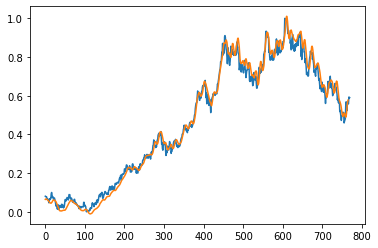

In [0]:
loss_train, predictions_train = evaluate(time_steps, foresee_date, data_train_tensor, target_train_tensor, model, criterion)

plt.plot(target_train_np[:,1])
plt.plot(predictions_train[:,0,1])

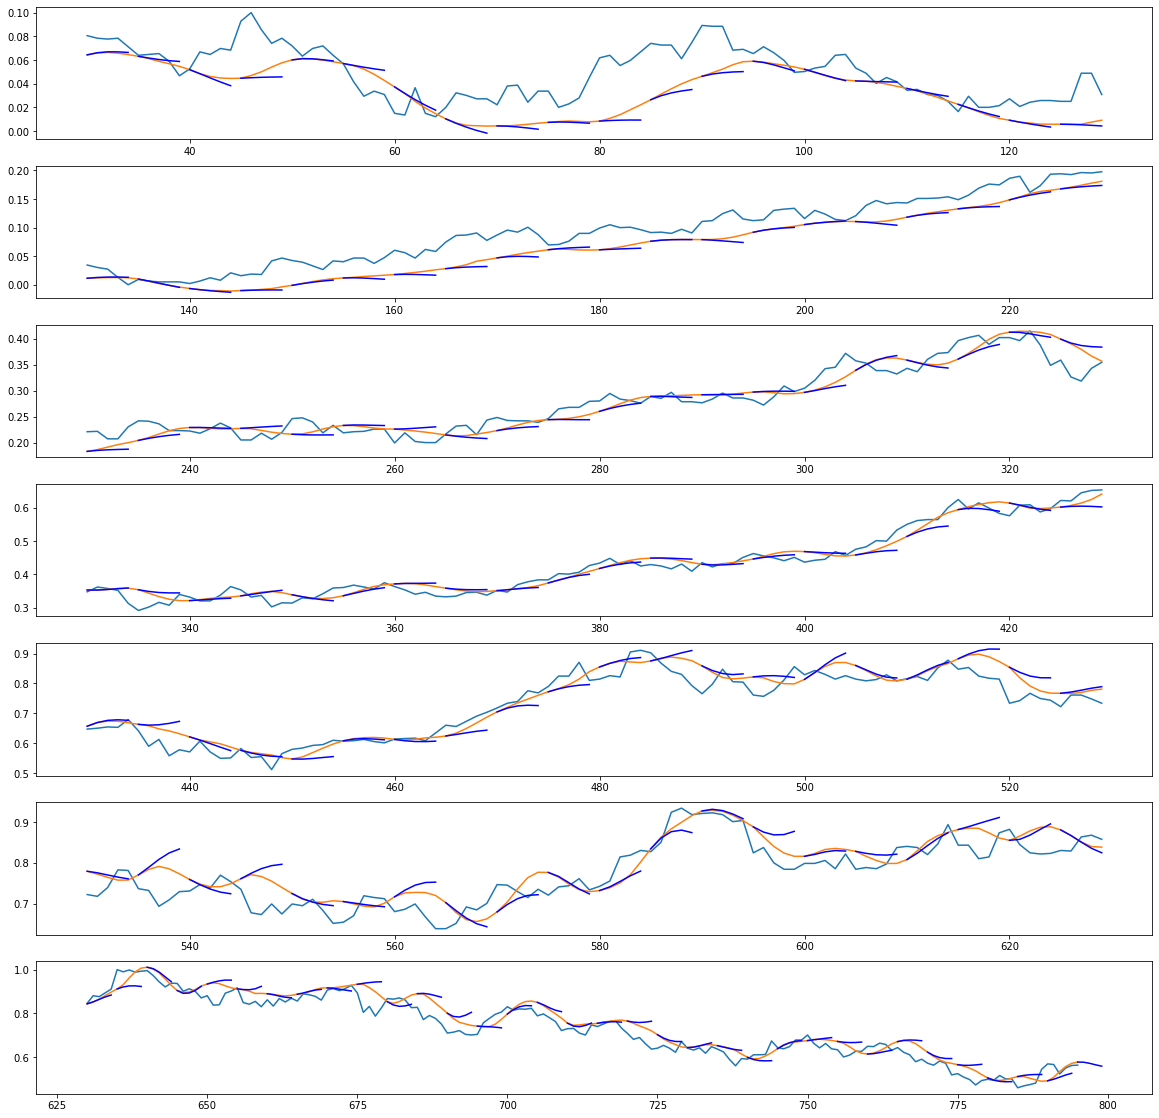

In [0]:
loss_train, predictions_train = evaluate(time_steps, foresee_date, data_train_tensor, target_train_tensor, model, criterion)
# In [46]: fig = plt.figure()
# In [48]: ax1 = fig.add_subplot(2, 1, 1)
# In [49]: ax2 = fig.add_subplot(2, 1, 2)
# In [50]: plt.show()
d = 1
#plt.figure(figsize=(100, 5))
fig = plt.figure(figsize=(20, 20))

ax = []
for i in range(7):
  ax.append(fig.add_subplot(7,1,i+1)) 
# ax1 = fig.add_subplot(7,1,1)
# ax2 = fig.add_subplot(7,1,2)
# ax3 = fig.add_subplot(7,1,3)
# ax4 = fig.add_subplot(7,1,4)
# ax5 = fig.add_subplot(7,1,5)
# ax6 = fig.add_subplot(7,1,6)
# ax7 = fig.add_subplot(7,1,7)
step = 100
for i in range(1,8):
  start = (i-1) * step

  if i == 7: end = predictions_train.shape[0]
  else: end = i * step

 # try:
  ax[i-1].plot(target_train_np[0:,0][start:end],target_train_np[0:,1][start:end])
  ax[i-1].plot(predictions_train[:,0,0][start:end],predictions_train[:,0,1][start:end])
  for j in range(start, end):
    if j%foresee_date == 0:
      ax[i-1].plot(predictions_train[:,:,0][j],predictions_train[:,:,1][j], color = 'b')
  #except: print(i)

#plt.plot(predictions_train[:,:,0],predictions_train[:,:,1])

In [0]:
#print(target_train_np[d - 1:,1])
#print(predictions_train[:,d-1,1])
#print(pre_with_time)
print(predictions_train[:,:,1][:100])
print(predictions_train[:,:,0][0])
#print(predictions_train[:2,:,1])
print(predictions_train.shape[0])

[[ 0.07403223  0.07724723  0.0806095   0.08179405  0.08368528]
 [ 0.06323211  0.06647903  0.06994208  0.07112671  0.07302457]
 [ 0.06719374  0.07041889  0.07377507  0.07495295  0.07683301]
 [ 0.0632731   0.06651466  0.06986969  0.07105124  0.07288997]
 [ 0.06365304  0.06689189  0.07025161  0.07141316  0.07325822]
 [ 0.06452636  0.06775514  0.07111531  0.07227422  0.07412492]
 [ 0.05042113  0.05371559  0.05722408  0.05839453  0.06029439]
 [ 0.05055884  0.05385509  0.05728481  0.05845521  0.06036204]
 [ 0.05165637  0.05494325  0.05843243  0.0595751   0.06152286]
 [ 0.04446036  0.04778988  0.05133707  0.05249983  0.05447692]
 [ 0.02536423  0.02877967  0.03254779  0.03370331  0.03578218]
 [ 0.03200438  0.03539555  0.03897196  0.04013175  0.0422026 ]
 [ 0.05316467  0.05645674  0.0598578   0.06098785  0.0629855 ]
 [ 0.04946353  0.0527774   0.05624552  0.05740334  0.05934753]
 [ 0.05061242  0.05392032  0.05740255  0.05855245  0.06051094]
 [ 0.05476122  0.05804481  0.06143209  0.06259816  0.06

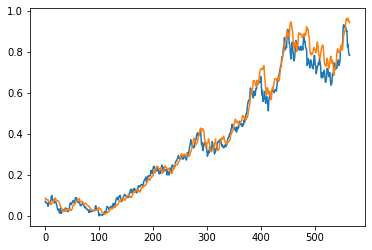

In [0]:
loss_train, predictions_train = evaluate(time_steps,foresee_date, data_train_tensor, target_train_tensor, model, criterion)

d = 5
plt.plot(target_train_np[d - 1:,1])
plt.plot(predictions_train[:,d - 1,1])

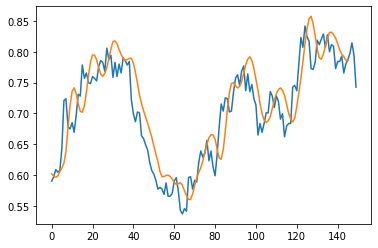

In [0]:
loss_val, predictions_val = evaluate(time_steps,foresee_date, data_val_tensor, target_val_tensor, model, criterion)

d = 1

plt.plot(target_val_np[d - 1:,1])
plt.plot(predictions_val[:,d - 1,1])

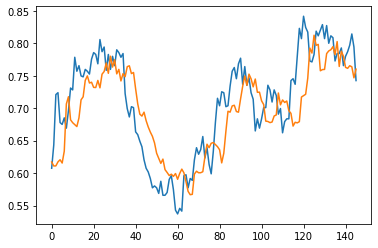

In [0]:
loss_val, predictions_val = evaluate(time_steps, data_val_tensor, target_val_tensor, model, criterion)

d = 5

plt.plot(target_val_np[d - 1:,1])
plt.plot(predictions_val[:,d - 1,1])

In [0]:
optimizer = optim.Adam(model.parameters(), lr = lr/3)

for ep in range(200):
  start_time = time.time()
  if shuffle:
    random.shuffle(train_batches)
  train_loss = train(time_steps, train_batches, model, optimizer, criterion)
  end_time = time.time()
  if ep%50 == 0:
    print(train_loss)



0.005355742915333418
0.004987676537227377
0.004653520136008174
0.005393758758619343


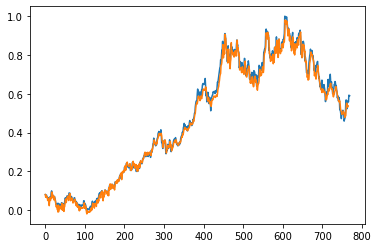

In [0]:
loss_train, predictions_train = evaluate(time_steps, data_train_tensor, target_train_tensor, model, criterion)

d = 1
plt.plot(target_train_np[d - 1:,1])
plt.plot(predictions_train[:,d - 1,1])

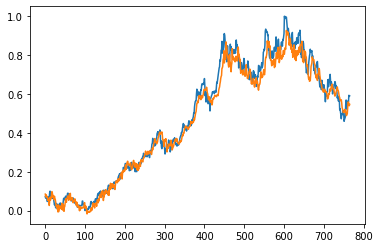

In [0]:
loss_train, predictions_train = evaluate(time_steps, data_train_tensor, target_train_tensor, model, criterion)

d = 5
plt.plot(target_train_np[d - 1:,1])
plt.plot(predictions_train[:,d - 1,1])

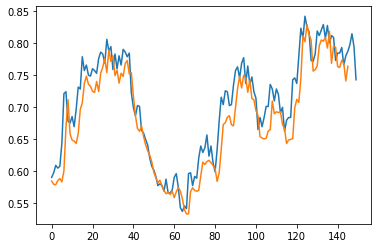

In [0]:
loss_val, predictions_val = evaluate(time_steps, data_val_tensor, target_val_tensor, model, criterion)

d = 1

plt.plot(target_val_np[d - 1:,1])
plt.plot(predictions_val[:,d - 1,1])

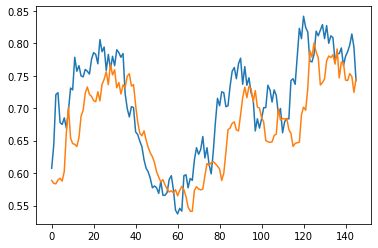

In [0]:
loss_val, predictions_val = evaluate(time_steps, data_val_tensor, target_val_tensor, model, criterion)

d = 5

plt.plot(target_val_np[d - 1:,1])
plt.plot(predictions_val[:,d - 1,1])

In [0]:
optimizer = optim.Adam(model.parameters(), lr = lr/5)

for ep in range(200):
  start_time = time.time()
  train_loss = train(time_steps, train_batches, model, optimizer, criterion)
  end_time = time.time()
  if ep%50 == 0:
    print(train_loss)

0.004801225665092271
0.005548628140236411
0.004162301008989877


KeyboardInterrupt: ignored

In [0]:
loss_train, predictions_train = evaluate(time_steps, data_train_tensor, target_train_tensor, model, criterion)

d = 5

print(predictions_train.shape)
print(target_train_np.shape)

plt.plot(target_train_np[d - 1:,1][300:500])
plt.plot(predictions_train[:,d - 1,1][300:500])

print(target_train_np[d - 1,0])
print(predictions_train[0,d-1,0])


In [0]:
loss_val, predictions_val = evaluate(time_steps, data_val_tensor, target_val_tensor, model, criterion)

d = 5

plt.plot(target_val_np[d - 1:,1])
plt.plot(predictions_val[:,d - 1,1])

